
# 16124278 王浩 week 3 
Cifar_10_图像识别 由于数据集较大且训练模型较为复杂，可训练参数多达142万，
即使在本地使用GPU（MX150）运行仍需接近一天时间，
故本程序借助Google Colab利用GPU加速（约1h）在云端运行。

最终在训练集上的准确率为：96.88%   验证集上的准确率为：97.05%   测试集上的准确率为：96.97%

*注：由于暂时无法在colab中引用本地图片，文中所有图片均为本地图片上传至GitHub后的网页链接*

[本地图片链接（GitHub）](https://github.com/MirstT/Colab_Cifar10_Image-recognition/)
## 打印Colab目前连接使用机器（GPU）信息


In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

#打印相关信息
printm()

Gen RAM Free: 11.3 GB  | Proc size: 143.1 MB
GPU RAM Free: 3039MB | Used: 8402MB | Util  73% | Total 11441MB


## 建立ipynb与Google云盘的连接
将训练模型以及日志文件储存在自己的云盘文件中，
同时方便以后使用本地数据集/本地模板库。

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_08-08-39.png?raw=true)

登录代码：

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_16-14-21.png?raw=true)

In [1]:
# 安装相关文件
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# 账号信息授权
from google.colab import auth
auth.authenticate_user()
#授权码1
#4/JwE_0WWiynLrN7mj3bfRDFe6R4jhjc2hKcSb59vXE816ZAyt2kCyjXM

# 账号密码授权
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#授权码2
#4/JwHPn1brf-kYZU5L6pmu4XsF7Ckdhs-h9aXh93BLCYk-bMQKa1r-dks

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

## Google云盘工作文件夹设置
显示工作目录下的内容（和linux系统下命令基本相同）
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_15-36-19.png?raw=true)


In [6]:
# 指定Google Drive云端硬盘的根目录，名为wh_drive
!mkdir -p wh_drive
!google-drive-ocamlfuse wh_drive


# 指定当前的工作文件夹
import os
os.chdir("wh_drive/Colab") 


# 显示工作目录下的内容
! ls 

 Advanced_Data_Analysis		      models
'Advanced_Data_Analysis (28c5583b)'  'models (5069b798)'
 char-09.ipynb			      old_Cifar_10_图像识别.ipynb
 logs				      WH_2019-04-09_08-08-39.png
'logs (36bf767a)'		      wh_drive
 mnist_mlp.ipynb


## Cifar10数据集下载导入与归一化
服务器网速很快，不需要从云盘中读取数据集，直接下载到colab服务器运行即可

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#设置随机种子
np.random.seed(161)

from keras.datasets import cifar10

#读取数据集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

Using TensorFlow backend.


170500096/170498071 [==============================] - 14s 0us/step


## Cifar10数据预处理
将彩色图片转为灰度图片：
灰度值 = 0.2989 * 红色 + 0.5870 * 绿色 + 0.1140 * 蓝色

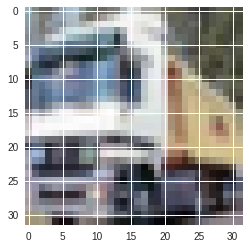

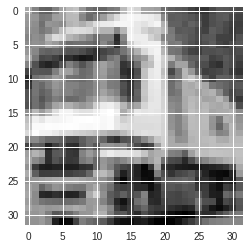

In [3]:
#选取彩色通道，将图片转换为灰度图
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

#大小统一为32*32像素
x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

plt.imshow(x_train[1])
plt.show()

plt.imshow(x_train_gray[1,:,:,0], cmap='gray')
plt.show()

## 模型搭建（基于Inception架构）
获得高质量模型最保险的做法就是增加模型的深度（层数）或者是其宽度（层核或者神经元数），

但是一般设计思路的情况下会出现如下的缺陷：

1.参数太多，若训练数据集有限，容易过拟合；

2.网络越大计算复杂度越大，难以应用；

3.网络越深，梯度越往后穿越容易消失，难以优化模型。 


解决上述两个缺点的根本方法是将全连接甚至一般的卷积都转化为稀疏连接。

## Inception架构的主要思想是找出如何用密集成分来近似最优的局部稀疏结。
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_17-29-26.png?raw=true)

1.   采用不同大小的卷积核意味着不同大小的感受野，最后拼接意味着不同尺度特征的融合；
2.   之所以卷积核大小采用1*1、3*3和5*5，主要是为了方便对齐。设定卷积步长stride=1之后，只要分别设定padding =0、1、2，采用same卷积可以得到相同维度的特征，然后这些特征直接拼接在一起； 
3.   很多论文都表明pooling挺有效，所以Inception里面也嵌入了pooling。
4.   减少计算成本，采用1x1卷积核来进行降维

Inception的作用：代替人工确定卷积层中的过滤器类型或者确定是否需要创建卷积层和池化层，即：不需要人为的决定使用哪个过滤器，是否需要池化层等，由网络自行决定这些参数，可以给网络添加所有可能值，将输出连接起来，网络自己学习它需要什么样的参数。

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/graph_large_attrs_key=_too_large_attrs&limit_attr_size=1024&run=.png?raw=true)




In [13]:
import datetime # 输出模型日期后缀

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model



# 自定义全连接层
def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
  
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    # 视条件而定 使用dropout/normalization
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

  
  
# 构建一个Inception模型
def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2): 
  
    # feature_nr 是一个用来构建一个inception内部网络层的数组
    # 其数据形式为: [1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool proj]
    
    # 1*1 卷积核  
    inception_1x1 = Conv2D(features_nr[0],1,1,border_mode='same',activation='relu',name='inception_%d_/1x1'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    # 1. 实现跨通道的交互和信息整合；2. 进行卷积核通道数的降维
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,border_mode='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer) 
    
    # 3*3 卷积核
    inception_3x3 = Conv2D(features_nr[2],3,3,border_mode='same',activation='relu',name='inception_%d_/3x3'%(module_nr),W_regularizer=l2(0.0002))(inception_3x3_reduce)
    
    # 1. 实现跨通道的交互和信息整合；2. 进行卷积核通道数的降维
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,border_mode='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    # 5*5 卷积核
    inception_5x5 = Conv2D(features_nr[4],5,5,border_mode='same',activation='relu',name='inception_%d_/5x5'%(module_nr),W_regularizer=l2(0.0002))(inception_5x5_reduce)
    
    # max pooling 核
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),border_mode='same',name='inception_%d_/pool'%(module_nr))(input_layer)
    
    # 1. 实现跨通道的交互和信息整合；2. 进行卷积核通道数的降维
    inception_pool_proj = Conv2D(features_nr[5],1,1,border_mode='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr),W_regularizer=l2(0.0002))(inception_pool)
    
    # inception 输出
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    # 视条件而定 使用dropout/normalization
    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)
    
    # maxpooling层最终输出（2*2）
    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return pooled

#模型名称
i='cifar10-nrcrt7-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

#在Google云盘创建储存模型与日志的文件夹（工作目录下创建）
!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#如果验证集loss值连续10个周期不下降，程序自动停止（早停法）
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#每个训练周期后，验证集loss值如果下降，则储存改模型（最终只储存最好的模型）
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#保存日志文件至Google云盘中

#回调函数：当评价指标不在提升时，减少学习率 （loss值连续5次没有变化时，学习率缩小十倍）
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------模型参数定义-------------------

use_norm = True
lrate = 0.001 #学习率

input_img = Input(shape = (32, 32, 3), name='input') #数据输入

inception_1 = build_inception_module(input_img, [64,96,128,16,32,32], 1, False, use_norm) #inception_1

inception_2 = build_inception_module(inception_1, [128,128,192,32,96,64], 2, False, use_norm)#inception_2

inception_3 = build_inception_module(inception_2, [192,96,208,16,48,64], 3, False, use_norm)#inception_3

inception_4 = build_inception_module(inception_3, [160, 112, 224, 24, 64, 64], 4, False, use_norm)#inception_4

flat_pool = AveragePooling2D(pool_size=(2, 2), padding='valid')(inception_4) #平均池化

flat = Flatten()(flat_pool)

dense_5 = build_dense(flat, 128, 1, True, use_norm) # 全连接层

dense_6 = build_dense(dense_5, 64, 2, True, use_norm) # 全连接层

out = Dense(10, activation='softmax')(dense_6) # 最后一层使用softmax激活函数

model = Model(inputs = input_img, outputs = out)# 输出

#-----------------------------------------------

model.compile(loss='binary_crossentropy', #暂时不理解这里为什么要使用二分类的损失函数（该模型不是多标签，而是多分类，理应使用多分类中应使用的损失函数）
              optimizer=Adam(lrate),
              metrics=['accuracy']) #设置损失函数和优化器

model.summary()

#将模型转换为json文件
model_json = model.to_json()
with open("./models/"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("已将模型储存至" + "../models/"+str(i)+".json")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", name="inception_1_/1x1", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 1), activation="relu", name="inception_1_/3x3_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="inception_1_/3x3", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="inception_1_/5x5_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
inception_1_/3x3_reduce (Conv2D (None, 32, 32, 96)   384         input[0][0]                      
__________________________________________________________________________________________________
inception_1_/5x5_reduce (Conv2D (None, 32, 32, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
inception_1_/pool (MaxPooling2D (None, 32, 32, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
inception_

## 运行内存
模型运行时内存统计（参数）

In [14]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("内存使用 (GB):", get_model_memory_usage(128,model))

内存使用 (GB): 1.47


## 模型训练
使用GPU加速训练过程，并将训练所得模型保存至Google云盘

In [17]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit(x_train, y_train_cat, batch_size=128, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # 开始训练 100个周期

  
  
result = model.evaluate(x_test, y_test_cat)

print("准确率（测试集）: ",result[1]*100,"%")

#将模型与日志拷贝至Google云盘
!cp -R models Advanced_Data_Analysis
!cp -R logs Advanced_Data_Analysis

print("已将模型与日志拷贝至Google云盘")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 74s 2ms/step - loss: 0.5179 - acc: 0.9181 - val_loss: 0.3985 - val_acc: 0.9079

Epoch 00001: val_loss improved from inf to 0.39853, saving model to ./models/cifar10-nrcrt7-09:19AM_April-09-2019.hdf5
Epoch 2/100
40000/40000 [==============================] - 72s 2ms/step - loss: 0.2953 - acc: 0.9337 - val_loss: 0.3147 - val_acc: 0.9185

Epoch 00002: val_loss improved from 0.39853 to 0.31475, saving model to ./models/cifar10-nrcrt7-09:19AM_April-09-2019.hdf5
Epoch 3/100
40000/40000 [==============================] - 71s 2ms/step - loss: 0.2459 - acc: 0.9416 - val_loss: 0.2898 - val_acc: 0.9257

Epoch 00003: val_loss improved from 0.31475 to 0.28980, saving model to ./models/cifar10-nrcrt7-09:19AM_April-09-2019.hdf5
Epoch 4/100
40000/40000 [==============================] - 72s 2ms/step - loss: 0.2246 - acc: 0.9468 - val_loss: 0.2508 - val_acc: 0.9380

Epoch 00004: val_loss improve

## 模型的准确率和loss值

### 训练集
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_18-17-40.png?raw=true)
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_18-17-48.png?raw=true)

### 验证集
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_18-17-57.png?raw=true)
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_18-18-05.png?raw=true)

*注：程序运行至第32个周期时自动停止*



## 模型测试
cifar10-nrcrt7-09:19AM_April-09-2019.hdf5

导入模型，在测试集上进行测试，输出loss值和准确率

In [18]:
model.load_weights('./models/cifar10-nrcrt7-09:19AM_April-09-2019.hdf5')

result = model.evaluate(x_test, y_test_cat)

print(result)

10000/10000 [==============================] - 8s 764us/step
[0.1395178472995758, 0.969710001373291]
